<a href="https://colab.research.google.com/github/Nawel-Bellil/AI---Deep-Learning--/blob/main/DL_Chapter_03_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



 **Temperature Forecasting**

During this workshop, you will learn about sequential data. First, you will use a simple Dense network, then a CNNs. Then, you will try LSTMs networks and GRUs, to assess the difference between what you've learned during the previous chapter (CNN models) and what you've seen during this chapter (RNNs and their variants) for sequential data.


In [ ]:
#Here we are getting the data. It is a climate data and we will work together on the temperature timeseries data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-08-16 18:39:51--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.137.240, 52.217.173.96, 54.231.128.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.137.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  81.1MB/s    in 0.2s    

2023-08-16 18:39:51 (81.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
#Inspecting the data of the Jena weather dataset

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
#Parsing the data

import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

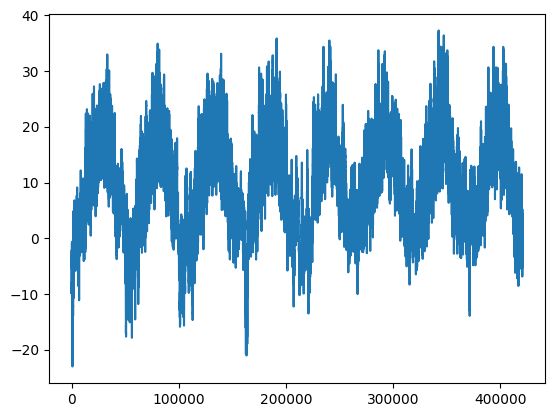

In [ ]:
#Plotting the temperature timeseries

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

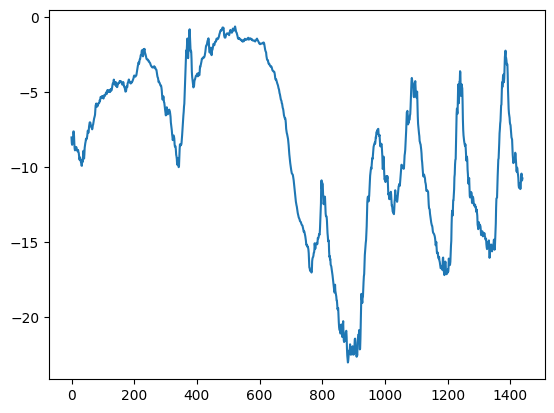

In [ ]:
#Plotting the first 10 days of the temperature timeseries

plt.plot(range(1440), temperature[:1440])

In [ ]:
#Computing the number of samples we'll use for each data split

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
#Preparing the data
#Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
#Instantiating datasets for training, validation, and testing

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
#Inspecting the output of one of our datasets

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
#Training and evaluating a densely connected model

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 72ms/step - loss: 15.6258 - mae: 3.0346 - val_loss: 15.8301 - val_mae: 3.1542
Epoch 2/10
819/819 [==============================] - 61s 74ms/step - loss: 9.1912 - mae: 2.3902 - val_loss: 10.8275 - val_mae: 2.6025
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 8.3695 - mae: 2.2830 - val_loss: 10.2414 - val_mae: 2.5270
Epoch 4/10
819/819 [==============================] - 54s 66ms/step - loss: 7.9295 - mae: 2.2256 - val_loss: 11.4417 - val_mae: 2.6662
Epoch 5/10
819/819 [==============================] - 54s 65ms/step - loss: 7.5790 - mae: 2.1768 - val_loss: 10.7839 - val_mae: 2.5995
Epoch 6/10
819/819 [==============================] - 58s 71ms/step - loss: 7.3321 - mae: 2.1451 - val_loss: 11.6279 - val_mae: 2.6860
Epoch 7/10
819/819 [==============================] - 58s 71ms/step - loss: 7.1294 - mae: 2.1168 - val_loss: 10.9345 - val_mae: 2.6156
Epoch 8/10
819/819 [==============================] - 

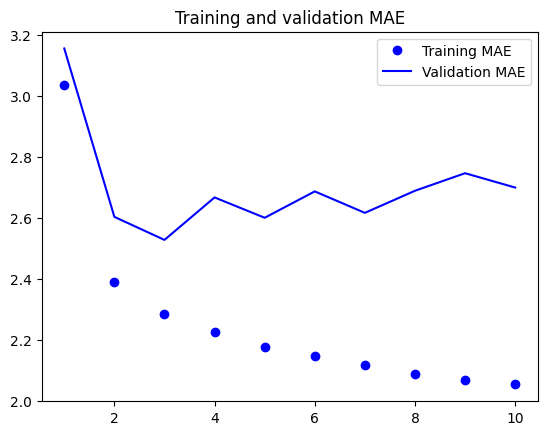

In [ ]:
#Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
#1- Let's try a 1D convolutional model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 95s 114ms/step - loss: 22.0950 - mae: 3.6851 - val_loss: 16.7040 - val_mae: 3.2704
Epoch 2/10
819/819 [==============================] - 92s 112ms/step - loss: 15.3380 - mae: 3.1101 - val_loss: 14.7877 - val_mae: 3.0055
Epoch 3/10
819/819 [==============================] - 92s 112ms/step - loss: 14.0762 - mae: 2.9736 - val_loss: 16.1568 - val_mae: 3.1319
Epoch 4/10
819/819 [==============================] - 128s 156ms/step - loss: 13.2726 - mae: 2.8811 - val_loss: 15.8500 - val_mae: 3.1675
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 12.6399 - mae: 2.8101 - val_loss: 18.1689 - val_mae: 3.3596
Epoch 6/10
819/819 [==============================] - 96s 117ms/step - loss: 12.1486 - mae: 2.7541 - val_loss: 13.8479 - val_mae: 2.9131
Epoch 7/10
819/819 [==============================] - 97s 118ms/step - loss: 11.7438 - mae: 2.7081 - val_loss: 15.0554 - val_mae: 3.0413
Epoch 8/10
819/819 [===================

In [ ]:
#2 - Trying a simple LSTM-based model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 133s 159ms/step - loss: 38.6891 - mae: 4.5098 - val_loss: 12.0873 - val_mae: 2.6604
Epoch 2/10
819/819 [==============================] - 113s 137ms/step - loss: 10.5920 - mae: 2.5360 - val_loss: 9.9563 - val_mae: 2.4506
Epoch 3/10
819/819 [==============================] - 130s 158ms/step - loss: 9.6536 - mae: 2.4220 - val_loss: 9.7705 - val_mae: 2.4414
Epoch 4/10
819/819 [==============================] - 114s 138ms/step - loss: 9.1835 - mae: 2.3580 - val_loss: 9.7783 - val_mae: 2.4290
Epoch 5/10
819/819 [==============================] - 111s 135ms/step - loss: 8.7906 - mae: 2.3097 - val_loss: 9.6905 - val_mae: 2.4185
Epoch 6/10
819/819 [==============================] - 111s 135ms/step - loss: 8.4968 - mae: 2.2720 - val_loss: 10.0789 - val_mae: 2.4756
Epoch 7/10
819/819 [==============================] - 115s 140ms/step - loss: 8.2876 - mae: 2.2435 - val_loss: 9.9005 - val_mae: 2.4451
Epoch 8/10
819/819 [========================

In [ ]:
#3- Training and evaluating a dropout-regularized, stacked GRU model


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 431s 512ms/step - loss: 26.9327 - mae: 3.8129 - val_loss: 9.6546 - val_mae: 2.4183
Epoch 2/10
819/819 [==============================] - 408s 498ms/step - loss: 14.0498 - mae: 2.9062 - val_loss: 8.9147 - val_mae: 2.3081
Epoch 3/10
819/819 [==============================] - 405s 494ms/step - loss: 13.3017 - mae: 2.8278 - val_loss: 9.4150 - val_mae: 2.3806
Epoch 4/10
819/819 [==============================] - 353s 430ms/step - loss: 12.6983 - mae: 2.7668 - val_loss: 8.8945 - val_mae: 2.3278
Epoch 5/10
819/819 [==============================] - 400s 488ms/step - loss: 12.2092 - mae: 2.7116 - val_loss: 9.0093 - val_mae: 2.3344
Epoch 6/10
819/819 [==============================] - 393s 479ms/step - loss: 11.8111 - mae: 2.6658 - val_loss: 8.8746 - val_mae: 2.3106
Epoch 7/10
819/819 [==============================] - 358s 436ms/step - loss: 11.4458 - mae: 2.6245 - val_loss: 9.6177 - val_mae: 2.4142
Epoch 8/10
819/819 [=====================

After trying all those networks on Timeseries data, you can see that the Mean Absolute Error (MAE) is decreasing when using LSTM compared to CNN. This is a proof that RNNs and especially LSTMs are more suitable for sequential and timeseries data.
You can try other architecture of RNNs and compare the results.
You may even try the same procedure on another sequential dataset.